In [31]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [32]:
data = pd.read_csv('data/FE_training_set.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)


In [33]:
data['target'] = 4* data['booking_bool'] + data['click_bool']
data['target'].loc[data['target'].isna()] = int(0)
data['target'] = data['target'].astype(int)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_55367/251966437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].loc[data['target'].isna()] = int(0)


<Axes: >

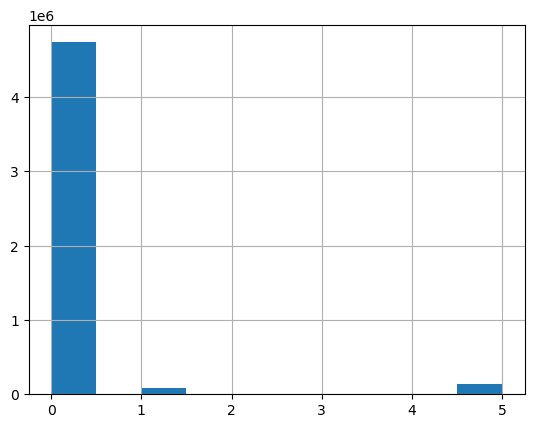

In [34]:
data['target'].hist()

In [35]:
data['target'].value_counts()

0    4736468
5     138390
1      83489
Name: target, dtype: int64

In [36]:
data.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,country_pct_rank,comp_mean_rate,comp_better_rate,comp_mean_inv,comp_better_inv,price_change,desirability_score,percentile_of_day,within_us,target
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,0.65,-0.012522,1,-0.009119,1,-0.257871,0.001449,0.355729,-1,0
1,498,32,220,NaN,NaN,219,893,3,3.5,1,...,0.65,-0.012522,1,-0.009119,1,-0.380268,0.001449,0.480810,-1,0
2,896,5,2,NaN,NaN,219,893,3,3.5,1,...,0.65,-0.012522,1,-0.009119,1,-0.133868,0.001449,0.927049,-1,0
3,1495,5,219,NaN,NaN,219,893,3,3.5,1,...,0.65,-0.012522,1,-0.009119,1,-0.044505,0.001449,0.100023,2,0
4,2052,5,219,NaN,NaN,219,893,3,3.5,1,...,0.65,-0.012522,1,-0.009119,1,-0.235591,0.001449,0.340590,2,0


In [37]:
# get search ids with any booking
ids = data['srch_id'].loc[data['booking_bool'] == 1].unique()

In [38]:
# use only the searches that resulted in a booking
data = data.loc[data['srch_id'].isin(ids)]

In [39]:
# undersample non bookings
X_under, y_under = resample(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[data['target'] == 0], data['target'].loc[data['target'] == 0]
                                      , n_samples=1 * sum(data['target'] != 0), replace=False)

In [40]:
X_bal = pd.concat([X_under, data.drop(['srch_id','click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[data['target'] != 0]])

y_bal = y_under
y_bal = y_bal.append(data['target'].loc[data['target'] != 0])

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_55367/1700962643.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_bal = y_bal.append(data['target'].loc[data['target'] != 0])


In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)
X_train, y_train = X_bal, y_bal

In [44]:
categoricals = ['prop_country_id', 'prop_starrating','prop_brand_bool', 'promotion_flag',
                'srch_saturday_night_bool', 'random_bool']

#baseline = HistGradientBoostingRegressor(max_leaf_nodes=None, max_depth=4, categorical_features= categoricals)

# much better than just replacing with 0
X_train = X_train.fillna(-9999)
baseline = GradientBoostingRegressor(max_leaf_nodes=None, max_depth=4, max_features=int(np.sqrt(X_train.shape[1])))
baseline.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=4, max_features=6)

In [45]:
pred = baseline.predict(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [ ]:
mean_squared_error(data['target'], pred)

4.159268568551839

In [ ]:
pred_test = baseline.predict(X_test.fillna(-9999))
mean_squared_error(y_test, pred_test)

4.311235914133998

In [ ]:
pred

array([ 1.81946419e+00,  1.87634015e+00,  1.45065001e+00, ...,
       -9.31620851e-02, -3.97005589e-04, -2.87932842e-01])

(array([114257.,      0.,  10635.,      0.,      0.,      0.,      0.,
             0.,      0., 103808.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

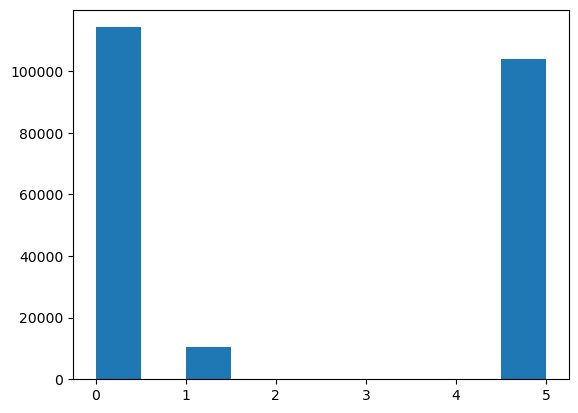

In [ ]:
plt.hist(y_train)

## Predict the test dataset and bring it into requested format

In [46]:
test_data = pd.read_csv('data/FE_test_set.csv')
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [47]:
test_data.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,prob_searchclick,country_pct_rank,comp_mean_rate,comp_better_rate,comp_mean_inv,comp_better_inv,price_change,desirability_score,percentile_of_day,within_us
0,1,12,187,NaN,NaN,219,893,3,3.5,1,...,0.026144,0.65,-0.012522,1,-0.009119,1,-0.257871,0.001449,0.355729,-1
1,498,32,220,NaN,NaN,219,893,3,3.5,1,...,0.026144,0.65,-0.012522,1,-0.009119,1,-0.380268,0.001449,0.480810,-1
2,896,5,2,NaN,NaN,219,893,3,3.5,1,...,0.026144,0.65,-0.012522,1,-0.009119,1,-0.133868,0.001449,0.927049,-1
3,1495,5,219,NaN,NaN,219,893,3,3.5,1,...,0.026144,0.65,-0.012522,1,-0.009119,1,-0.044505,0.001449,0.100023,2
4,2052,5,219,NaN,NaN,219,893,3,3.5,1,...,0.026144,0.65,-0.012522,1,-0.009119,1,-0.235591,0.001449,0.340590,2


In [48]:
test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position']
                                      , axis=1).fillna(-9999))

In [49]:
# sort values for final format
test_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [50]:
filename = 'data/predictions/prediction.csv'+str(datetime.now())
test_data[['srch_id', 'prop_id']].to_csv(filename, index=False)